# Initialisation

In [ ]:
# Check GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-9057f710-da79-bfc2-c9ed-72deacb9e3f4)


In [ ]:
# Check TensorFlow version
!pip install -U tf-nightly # TF version 2.12 has errors when cloning model, so using dev update

import tensorflow as tf
print(tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.14.0-dev20230601


In [ ]:
# Importing the helper_functions file
import os

if not os.path.exists('helper_functions.py'):
  !wget https://raw.githubusercontent.com/DavAll22/Extra-Code/main/helper_functions_TF.py
else:
  print("[INFO] 'helper_functions_TF.py' already exists, skipping download.")

--2023-06-02 06:48:39--  https://raw.githubusercontent.com/DavAll22/Machine-Learning/main/extra-code/helper_functions_TF.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12745 (12K) [text/plain]
Saving to: ‘helper_functions_TF.py.1’

helper_functions_TF 100%[===================>]  12.45K  --.-KB/s    in 0.001s  

2023-06-02 06:48:39 (21.2 MB/s) - ‘helper_functions_TF.py.1’ saved [12745/12745]



# Downloading the dataset

In [ ]:
# Get TensorFlow Datsets
import tensorflow_datasets as tfds

# Load in data
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=False,
                                             as_supervised=True,
                                             with_info=True)

In [ ]:
# Features of dataset
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

# Exploring the dataset

In [ ]:
# Take 1 sample of the trainig data
train_one_sample = train_data.take(1) # in format (image_tensor, label)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Output info about the sample
for image, label in train_one_sample:
  print(f'''
  Image shape: {image.shape}
  Image dtype: {image.dtype},
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  ''')


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>,
  Target class from Food101 (tensor form): 56
  Class name (str form): huevos_rancheros
  


In [ ]:
# Getting the original test sample class names index positions (for evaluations later)
test_one = test_data.take(len(test_data))
y_labels_original = []
for image, label in test_one:
  y_labels_original.append(label.numpy())
y_labels_original[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [ ]:
# Viewing the image tensor
image

<tf.Tensor: shape=(383, 512, 3), dtype=uint8, numpy=
array([[[162, 147, 116],
        [164, 149, 116],
        [167, 151, 118],
        ...,
        [ 90,  66,  38],
        [ 90,  66,  38],
        [ 90,  66,  38]],

       [[165, 150, 119],
        [165, 150, 117],
        [167, 151, 117],
        ...,
        [ 91,  67,  39],
        [ 90,  66,  38],
        [ 90,  66,  38]],

       [[168, 152, 119],
        [167, 151, 118],
        [166, 150, 116],
        ...,
        [ 92,  67,  37],
        [ 90,  65,  35],
        [ 90,  65,  35]],

       ...,

       [[153, 146, 138],
        [155, 151, 142],
        [161, 156, 150],
        ...,
        [125, 121, 110],
        [123, 117, 105],
        [120, 114, 102]],

       [[147, 140, 130],
        [152, 145, 135],
        [157, 153, 142],
        ...,
        [127, 124, 117],
        [125, 121, 112],
        [124, 117, 107]],

       [[145, 139, 127],
        [150, 144, 132],
        [157, 151, 139],
        ...,
        [127, 124, 11

In [ ]:
# Min and amx values of the image
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=251>)

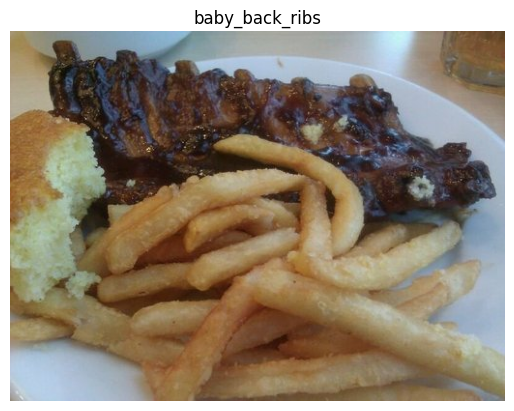

In [ ]:
# Plot the image tensor using Matplotlib
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on the class_names list
plt.axis(False);

# Preprocessing the data

In [ ]:
# Preprocess images function
def preprocess_img(image, label, img_shape=224):
  '''
  Converts image datatype from unit8 --> float32 and reshapes image to
  [img_shape, img_shape, colour_channels]
  '''
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [ ]:
# Preprocess one image and check outputs
preprocessed_img = preprocess_img(image, label)[0] # want the image tensor
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n") # returns first 2 output to reduce printing
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[162 147 116]
  [164 149 116]
  [167 151 118]
  ...
  [ 90  66  38]
  [ 90  66  38]
  [ 90  66  38]]

 [[165 150 119]
  [165 150 117]
  [167 151 117]
  ...
  [ 91  67  39]
  [ 90  66  38]
  [ 90  66  38]]]...,
Shape: (383, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[163.89413  148.89413  116.60842 ]
  [166.07143  150.07143  114.26036 ]
  [161.14062  146.21667  104.635994]
  ...
  [ 99.78344   73.569176  46.569176]
  [ 92.21203   68.21203   40.21203 ]
  [ 90.        66.        38.      ]]

 [[167.33865  151.33865  118.27391 ]
  [164.87723  148.93733  112.890625]
  [162.5067   147.77185  104.213806]
  ...
  [101.42853   75.89828   46.163403]
  [ 93.78776   68.78776   38.78776 ]
  [ 89.935265  64.935265  34.93527 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


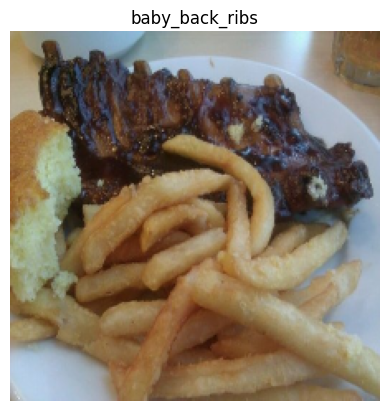

In [ ]:
# Plot preprocessed image by /255
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

## Batching and prefetching the dataset

In [ ]:
# Map preprocessing function to whole training data split
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data, turn into batches and prefetch
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to whole test data split
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# Model Callbacks

In [ ]:
# TensorBoard callback
from helper_functions_TF import create_tensorboard_callback

# ModelCheckpoint to save model's progress
checkpoint_path = 'model_cehckpoints/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_accuracy',
                                                      save_best_only=True, # only save best weights
                                                      save_weights_only=True,
                                                      verbose=0)

# Model Creation


*   Using mixed precision training 
*   Using transfer learning with EfficientNetB0 as the base model for feature extracting
    * Top layers not included to create a custom output layer for the dataset
    * Freeze base layers of the feature extractor to use the pre-trained patterns




In [ ]:
# Data augmentation
from tensorflow.keras.layers.experimental import preprocessing
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
  ],name="data_augumentation")

In [ ]:
# Mixed Precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy='mixed_float16')
mixed_precision.global_policy()

<Policy "mixed_float16">

In [ ]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False # freeze base model layers

inputs = layers.Input(shape=input_shape, name='input_layer')
# x = data_augmentation(input) # Uncomment for data augmentation (takes longer to run)
# x = base_model(x, training=False)
x = base_model(inputs, training=False) # base model set in inference mode
x = layers.GlobalAveragePooling2D(name='pooling_layer')(x)
x = layers.Dense(len(class_names))(x) # output 1 neuron per class
# Separate activation of output layer to output float32 activations
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model=tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', # labels not one-hot encoded
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                           

In [ ]:
# Checking the layers dtype policy
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


# Fitting the model

In [ ]:
# Turn off warnings except for errors
tf.get_logger().setLevel('ERROR')

In [ ]:
# Fit the model with callbacks
model_history_1 = model.fit(train_data,
                            epochs=3,
                            steps_per_epoch=len(train_data),
                            validation_data=test_data,
                            validation_steps=int(0.15*len(test_data)),
                            callbacks=[create_tensorboard_callback('training_logs', 'efficientnetb0_model_1'),
                                      model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_model_1/20230602-070403
Epoch 1/3
2368/2368 [==============================] - 247s 100ms/step - loss: 1.7162 - accuracy: 0.5823 - val_loss: 1.1243 - val_accuracy: 0.7018
Epoch 2/3
2368/2368 [==============================] - 185s 76ms/step - loss: 1.2009 - accuracy: 0.6894 - val_loss: 1.0313 - val_accuracy: 0.7156
Epoch 3/3
2368/2368 [==============================] - 181s 75ms/step - loss: 1.0560 - accuracy: 0.7234 - val_loss: 0.9921 - val_accuracy: 0.7283


In [ ]:
# Evaluating the model on whole dataset
model_results = model.evaluate(test_data)
model_results

790/790 [==============================] - 52s 66ms/step - loss: 1.0004 - accuracy: 0.7275


[1.0003684759140015, 0.7275247573852539]

## Cloning the model for fine tuning

In [ ]:
# Create a function to recreate the original model
def create_model():
  # Create base model
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.EfficientNetB0(include_top=False)
  base_model.trainable=False # fgreeze base model layers

  inputs = layers.Input(shape=input_shape, name='input_layer')
  x = base_model(inputs, training=False) # base model set in inference mode
  x = layers.GlobalAveragePooling2D(name='pooling_layer')(x)
  x = layers.Dense(len(class_names))(x) # output 1 neuron per class
  # Separate activation of output layer to output float32 activations
  outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
  model=tf.keras.Model(inputs, outputs)

  return model


In [ ]:
# Compile a new version of the original model
cloned_model = create_model()
cloned_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
# Load saved weights into the cloned model
cloned_model.load_weights(checkpoint_path)

In [ ]:
# Evaluate the model with the loaded weigths
cloned_model_results = cloned_model.evaluate(test_data)

790/790 [==============================] - 55s 65ms/step - loss: 1.0004 - accuracy: 0.7275


# Fine-Tuning

In [ ]:
# View trainable layers - each layer is not trainable
for layer in cloned_model.layers:
    layer.trainable = True # set all layers to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_2 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


## Callbacks #2

In [ ]:
# Early Stopping
# stops training if model val_loss does not improve after 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save the best model during fine-tuning
checkpoint_path = 'fine_tune_checkpoints/'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor='val_loss')

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=0.2,
                                                 verbose=1, #  Print out when learning rate goes down
                                                 min_lr=1e-7)

In [ ]:
# Compile the model
cloned_model.compile(loss='sparse_categorical_crossentropy', # sparse_categorical_crossentropy for labels that are *not* one-hot
                     optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                     metrics=['accuracy'])

In [ ]:
# Start fine-tuning all layers
cloned_model_history = cloned_model.fit(train_data,
                                        epochs=100,
                                        validation_data = test_data,
                                        validation_steps=int(0.15*len(test_data)), # validate on 15% of test data
                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_cloned_model"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements)

Saving TensorBoard log files to: training_logs/efficientb0_cloned_model/20230602-071630
Epoch 1/100
2368/2368 [==============================] - 457s 171ms/step - loss: 0.8721 - accuracy: 0.7634 - val_loss: 0.7559 - val_accuracy: 0.7895 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 0.5263 - accuracy: 0.8549
Epoch 2: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 380s 159ms/step - loss: 0.5263 - accuracy: 0.8549 - val_loss: 0.7857 - val_accuracy: 0.7847 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1952 - accuracy: 0.9496
Epoch 3: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
2368/2368 [==============================] - 369s 155ms/step - loss: 0.1952 - accuracy: 0.9496 - val_loss: 0.8019 - val_accuracy: 0.8096 - lr: 2.0000e-05
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1152 - accur

In [ ]:
cloned_model_results = cloned_model.evaluate(test_data)
cloned_model_results

790/790 [==============================] - 54s 68ms/step - loss: 0.8592 - accuracy: 0.8026


[0.8591552972793579, 0.8025742769241333]

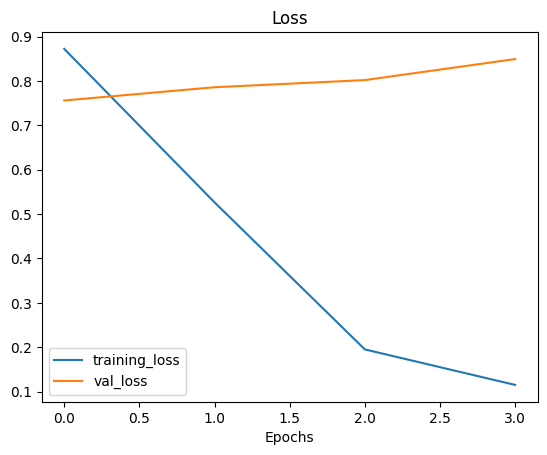

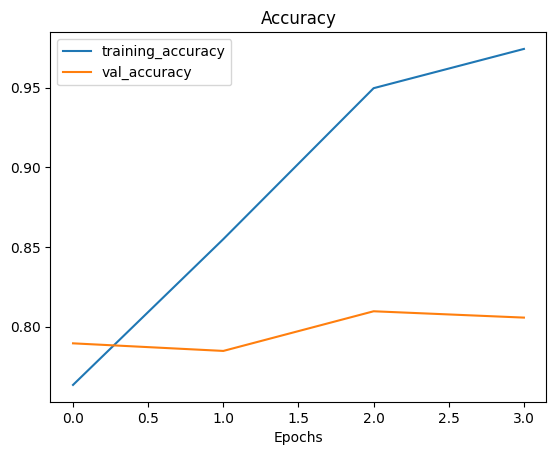

In [ ]:
from helper_functions_TF import plot_loss_curves
plot_loss_curves(cloned_model_history)

In [ ]:
cloned_model.save('food101_model')

# Making predictions

In [ ]:
# Getting prediction probabilities
pred_probs = cloned_model.predict(test_data, verbose=0)

In [ ]:
# How many predictions we have and the shape of predictions
len(pred_probs), pred_probs.shape

(25250, (25250, 101))

In [ ]:
# Visualising the prediction probabilities for sample 0
print(f'Number of prediction probabilities for sample 0: {len(pred_probs[0])}')
print(f'What prediction probability sample 0 looks like:\n {pred_probs[0]}')
print(f'The class with the highest predicted probability by the model in sample 0: {pred_probs[0].argmax()}')

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [1.4368453e-04 4.0711517e-14 2.3997762e-09 6.8858309e-13 3.4375203e-09
 5.3321562e-12 1.6169562e-11 3.2477435e-10 9.7984339e-05 7.1236151e-08
 6.3492087e-07 8.0503513e-13 3.8509899e-07 1.4647471e-06 4.1965706e-07
 7.1752005e-12 3.8371218e-05 1.3055148e-05 2.2261216e-15 5.9395027e-09
 1.0787477e-14 1.4994827e-06 8.2164865e-07 3.6383863e-08 4.3271997e-11
 8.2115821e-11 4.6521778e-10 5.2227165e-07 1.0816638e-09 9.9866807e-01
 2.6017908e-04 8.2983570e-06 2.0238581e-12 8.6316105e-17 1.7984228e-05
 8.3534606e-14 3.4717726e-08 5.5014166e-12 1.9728235e-13 1.2918631e-10
 7.8026680e-13 2.4171539e-13 2.1311944e-06 1.2684059e-15 1.4351303e-12
 4.4511391e-05 2.2933318e-12 7.7699281e-15 2.5438294e-11 6.7688788e-10
 1.9504218e-11 1.8038451e-11 6.8858309e-13 1.8294955e-08 2.2741265e-16
 2.0323861e-10 2.0093079e-08 6.8754730e-10 5.0741987e-04 1.6518249e-12
 1.1780267e-13 3.3508385e-10 1.0771251e-11 2.

In [ ]:
# Getting index position of the max value in each probability prediction tensor
## This index becomes the predicted class
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([ 29,  81,  91,  53,  97,  31,  10,  31,   3, 100])

In [ ]:
# y_labels = []
# for image, label in test_data.unbatch():
#   y_labels.append(label.numpy().argmax())
# y_labels[:10]

In [ ]:
# Using test dataset original labels before batching and prefetching (ground truth) - created at the beginning
# NOTE: will have to run above for shuffled dataset
y_labels_original[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [ ]:
len(y_labels_original)

25250

In [ ]:
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Evaluating the predictions

In [ ]:
# Confusion matrix for visualisation

# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


# class_names defined earlier

make_confusion_matrix(y_true=y_labels_original,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

## Evaluating F1-Score

In [ ]:
from sklearn.metrics import classification_report

# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels_original, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.6228813559322034,
  'recall': 0.588,
  'f1-score': 0.6049382716049382,
  'support': 250},
 '1': {'precision': 0.8214285714285714,
  'recall': 0.736,
  'f1-score': 0.7763713080168776,
  'support': 250},
 '2': {'precision': 0.8365758754863813,
  'recall': 0.86,
  'f1-score': 0.8481262327416174,
  'support': 250},
 '3': {'precision': 0.8203125,
  'recall': 0.84,
  'f1-score': 0.8300395256916997,
  'support': 250},
 '4': {'precision': 0.7276264591439688,
  'recall': 0.748,
  'f1-score': 0.73767258382643,
  'support': 250},
 '5': {'precision': 0.7222222222222222,
  'recall': 0.676,
  'f1-score': 0.6983471074380165,
  'support': 250},
 '6': {'precision': 0.8366533864541833,
  'recall': 0.84,
  'f1-score': 0.8383233532934131,
  'support': 250},
 '7': {'precision': 0.8914728682170543,
  'recall': 0.92,
  'f1-score': 0.905511811023622,
  'support': 250},
 '8': {'precision': 0.6860986547085202,
  'recall': 0.612,
  'f1-score': 0.6469344608879491,
  'support': 250},
 '9': {'

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.6049382716049382,
 'baby_back_ribs': 0.7763713080168776,
 'baklava': 0.8481262327416174,
 'beef_carpaccio': 0.8300395256916997,
 'beef_tartare': 0.73767258382643,
 'beet_salad': 0.6983471074380165,
 'beignets': 0.8383233532934131,
 'bibimbap': 0.905511811023622,
 'bread_pudding': 0.6469344608879491,
 'breakfast_burrito': 0.7292110874200426,
 'bruschetta': 0.7473460721868364,
 'caesar_salad': 0.8244575936883628,
 'cannoli': 0.8705882352941177,
 'caprese_salad': 0.7951807228915663,
 'carrot_cake': 0.7734375000000001,
 'ceviche': 0.6804979253112033,
 'cheesecake': 0.6769825918762089,
 'cheese_plate': 0.8369351669941061,
 'chicken_curry': 0.7540322580645162,
 'chicken_quesadilla': 0.8235294117647058,
 'chicken_wings': 0.8757637474541752,
 'chocolate_cake': 0.6958250497017893,
 'chocolate_mousse': 0.5977011494252874,
 'churros': 0.861111111111111,
 'clam_chowder': 0.8588235294117647,
 'club_sandwich': 0.8606060606060605,
 'crab_cakes': 0.7237354085603113,
 'creme_brulee': 0.

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

class_name  f1-score
33              edamame  0.991968
63             macarons  0.935743
54    hot_and_sour_soup  0.930894
91  spaghetti_carbonara  0.926441
69              oysters  0.924901

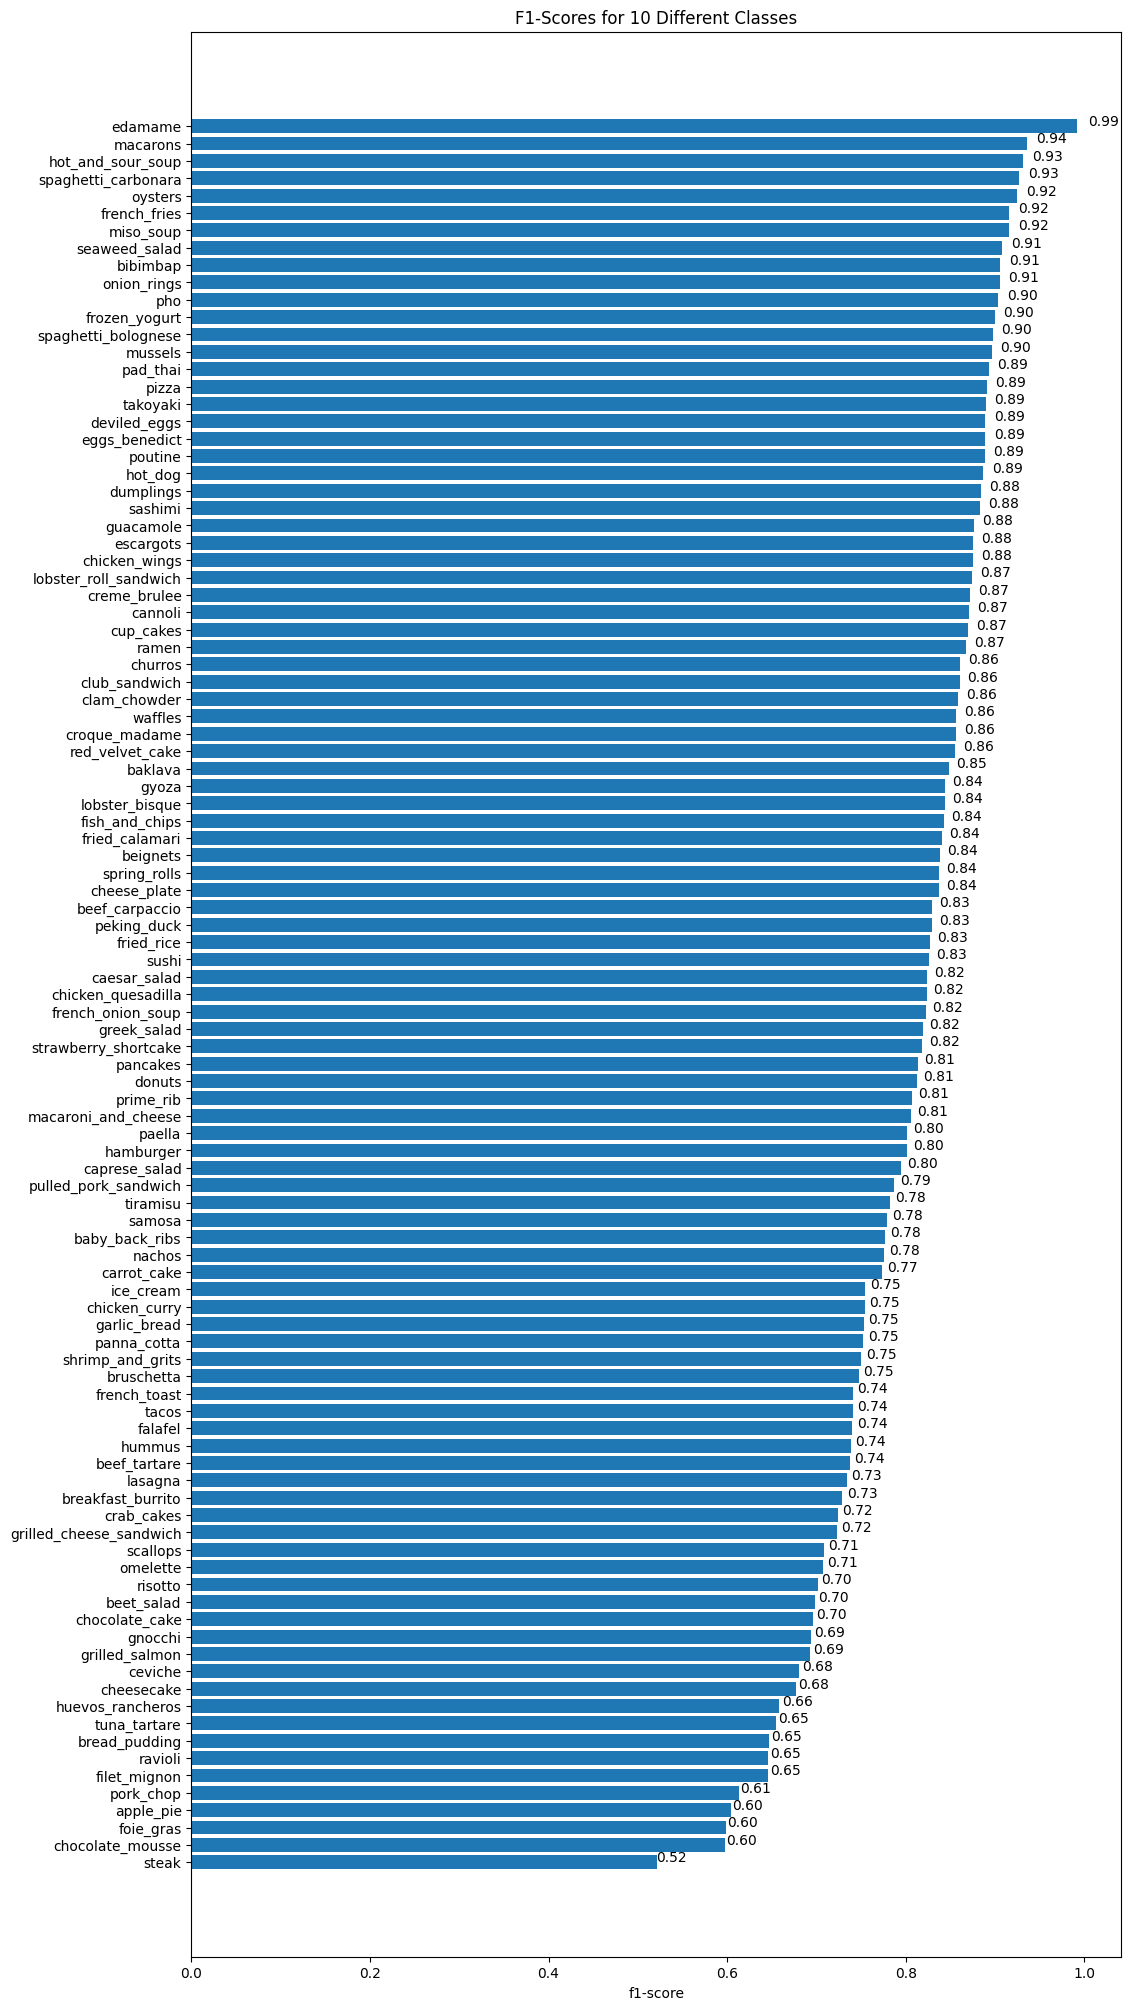

In [ ]:
# Visualising
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

# Predicting images